In [21]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns


In [22]:
# Load and resize images from a folder
def load_and_resize_images_from_folder(folder, size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            img_resized = img.resize(size)  # Resize image to the specified size
            images.append(np.array(img_resized))
    return images

# Load and preprocess data
def load_data():
    parasitized_data = load_and_resize_images_from_folder('parasitized')
    uninfected_data = load_and_resize_images_from_folder('uninfected')
    
    parasitized_labels = ['parasitized'] * len(parasitized_data)
    uninfected_labels = ['uninfected'] * len(uninfected_data)
    
    images = parasitized_data + uninfected_data
    labels = parasitized_labels + uninfected_labels
    
    images_np = np.array(images).astype('float32') / 255.0  # Normalize images
    labels_np = np.array(labels)
    
    encoder = LabelEncoder()
    labels_encoded = encoder.fit_transform(labels_np)
    
    return images_np, labels_encoded

# Load and prepare data
images, labels = load_data()


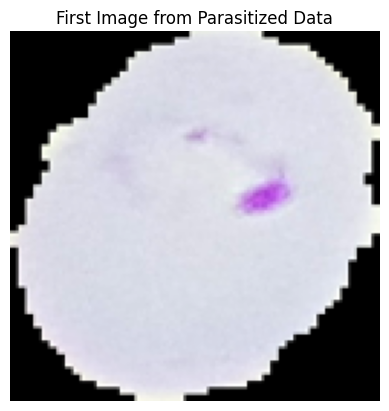

In [5]:
# Display the first image from the parasitized dataset
plt.imshow(images[0])
plt.title("First Image from Parasitized Data")
plt.axis('off')  # Hide axis
plt.show()


In [6]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)


In [23]:
# Data Augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No data augmentation for validation
val_datagen = ImageDataGenerator()

# Prepare data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)


In [27]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_simple_cnn(input_shape):
    model = Sequential([
        Input(shape=input_shape),  # Add Input layer as the first layer
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_shape = (128, 128, 3)
simple_cnn = build_simple_cnn(input_shape)


In [28]:
def build_vgg16(input_shape):
    vgg16_base = VGG16(include_top=False, input_shape=input_shape)
    model = Sequential([
        vgg16_base,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

vgg16_model = build_vgg16(input_shape)


In [25]:
def build_resnet50(input_shape):
    resnet50_base = ResNet50(include_top=False, input_shape=input_shape)
    model = Sequential([
        resnet50_base,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

resnet50_model = build_resnet50(input_shape)


In [29]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=0.00001)


In [38]:
# Train VGG16
print("Starting training...")
history_vgg16 = vgg16_model.fit(train_generator,
                                epochs=8, 
                                validation_data=val_generator,
                                callbacks=[early_stopping, lr_reduction])
print("Training completed!")


Starting training...
Epoch 1/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 2108s 3s/step - accuracy: 0.4965 - loss: 1.0178 - val_accuracy: 0.5074 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 2/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 2065s 3s/step - accuracy: 0.4972 - loss: 0.6932 - val_accuracy: 0.5074 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 3/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 2103s 3s/step - accuracy: 0.5127 - loss: 0.6931 - val_accuracy: 0.4926 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 4/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 2261s 3s/step - accuracy: 0.4991 - loss: 0.6932 - val_accuracy: 0.4926 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 5/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 2187s 3s/step - accuracy: 0.5027 - loss: 0.6932 - val_accuracy: 0.4926 - val_loss: 0.6932 - learning_rate: 5.0000e-04
Training completed!


In [34]:
print("Starting training...")
history_simple_cnn = simple_cnn.fit(
    train_generator,
    epochs=8,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_reduction],
    verbose=1  # Ensure verbose output is enabled
)
print("Training completed!")


Starting training...
Epoch 1/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 167s 241ms/step - accuracy: 0.9390 - loss: 0.1711 - val_accuracy: 0.9588 - val_loss: 0.1278 - learning_rate: 2.5000e-04
Epoch 2/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 168s 243ms/step - accuracy: 0.9390 - loss: 0.1758 - val_accuracy: 0.9585 - val_loss: 0.1254 - learning_rate: 2.5000e-04
Epoch 3/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 165s 238ms/step - accuracy: 0.9368 - loss: 0.1748 - val_accuracy: 0.9570 - val_loss: 0.1453 - learning_rate: 2.5000e-04
Epoch 4/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 161s 232ms/step - accuracy: 0.9331 - loss: 0.1826 - val_accuracy: 0.9597 - val_loss: 0.1267 - learning_rate: 2.5000e-04
Epoch 5/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 168s 243ms/step - accuracy: 0.9385 - loss: 0.1682 - val_accuracy: 0.9595 - val_loss: 0.1206 - learning_rate: 2.5000e-04
Epoch 6/8
689/689 ━━━━━━━━━━━━━━━━━━━━ 168s 244ms/step - accuracy: 0.9362 - loss: 0.1723 - val_accuracy: 0.9572 - val_loss: 0.1451 - learning_rate: 2.5000e-04
Epoch 7/8
689/689 ━━━━━━━

In [ ]:
# Save model weights
simple_cnn.save_weights('simple_cnn_weights.h5')
vgg16_model.save_weights('vgg16_weights.h5')

173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step
Confusion Matrix:
 [[2659  138]
 [  84 2631]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      2797
           1       0.95      0.97      0.96      2715

    accuracy                           0.96      5512
   macro avg       0.96      0.96      0.96      5512
weighted avg       0.96      0.96      0.96      5512



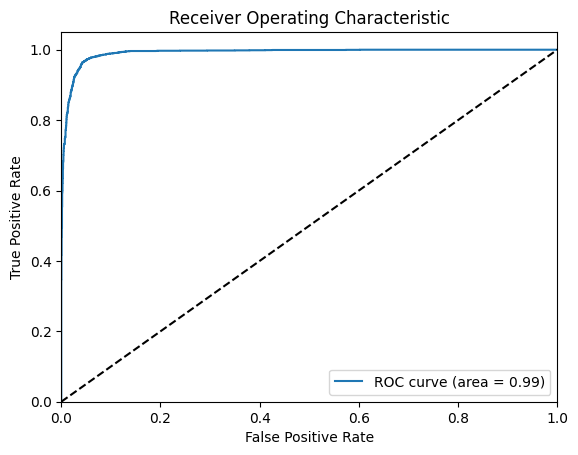

In [42]:
def evaluate_model(model, images, labels):
    predictions = (model.predict(images) > 0.5).astype("int32")
    cm = confusion_matrix(labels, predictions)
    cr = classification_report(labels, predictions)
    fpr, tpr, _ = roc_curve(labels, model.predict(images))
    roc_auc = auc(fpr, tpr)

    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", cr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

evaluate_model(simple_cnn, X_val, y_val)


# Evaluate VGG16
evaluate_model(vgg16_model, X_val, y_val)
